In [421]:
import os
import pandas as pd
import glob
from skimage import io
from nd2reader import ND2Reader
from skimage import feature, exposure, draw, morphology, filters, img_as_ubyte, measure, segmentation
import numpy as np
from tifffile import imwrite
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.stats import norm
from scipy.ndimage import gaussian_filter


In [422]:
# Function definitions

def reshape_to_rgb(grey_img):
    #makes single color channel image into rgb
    ret_img = np.zeros(shape=[grey_img.shape[0],grey_img.shape[1],3], dtype='uint8')
    grey_img_=img_as_ubyte(grey_img)

    ret_img[:,:,0]=grey_img_
    ret_img[:, :, 1] = grey_img_
    ret_img[:, :, 2] = grey_img_
    return ret_img

def draw_dot_on_img(draw_img, row, col, color, thickness=0):
    row = int(row)
    col = int(col)
    if(thickness==0):
        draw_img[row][col] = color
    else:
        for cur_r in range(row-thickness, row+thickness+1, 1):
            for cur_c in range(col-thickness, col+thickness+1,1):
                if(cur_r >=0 and cur_c >= 0 and cur_r < len(draw_img) and cur_c < len(draw_img[0])):
                    draw_img[cur_r][cur_c] = color

def draw_label_on_image(img, r, c, label, text_color=[1, 1, 1], text_size=0.3, text_lw=1, label_w=130, label_h=10):
    if (r + label_h) >= len(img):
        r_pos = r - ((r + label_h) - len(img))
    else:
        r_pos = r
    if (c + label_w) >= len(img[0]):
        c_pos = c - ((c + label_w) - len(img[0]))
    else:
        c_pos = c
    cv2.putText(img,
                label,
                (int(c_pos), int(r_pos)),
                cv2.FONT_HERSHEY_SIMPLEX,
                text_size,
                text_color,
                text_lw,
                cv2.LINE_AA)

def intensity_normalization(struct_img, scaling_param):

    '''
    Mode 1:  scaling_param = [0]
    Mode 2:  scaling_param = [lower std range, upper std range]
    Mode 3:  scaling_param = [lower std range, upper std range, lower abs intensity, higher abs intensity]
    '''
    assert len(scaling_param) > 0

    if len(scaling_param) == 1:
        if scaling_param[0] < 1:
            #print('intensity normalization: using min-max normalization with NO absolute intensity upper bound')
            pass
        else:
            #print(f'intensity normalization: using min-max normalization with absolute intensity upper bound {scaling_param[0]}')
            struct_img[struct_img > scaling_param[0]] = struct_img.min()
        strech_min = struct_img.min()
        strech_max = struct_img.max()
        struct_img = (struct_img - strech_min + 1e-8)/(strech_max - strech_min + 1e-8)
    elif len(scaling_param) == 2:
        # print(f'intensity normalization: normalize into [mean - {scaling_param[0]} x std, mean + {scaling_param[1]} x std] ')
        m, s = norm.fit(struct_img.flat)
        # print(m,s)
        # import numpy as np
        # import pdb; pdb.set_trace()
        strech_min = max(m - scaling_param[0] * s, struct_img.min())
        strech_max = min(m + scaling_param[1] * s, struct_img.max())
        struct_img[struct_img > strech_max] = strech_max
        struct_img[struct_img < strech_min] = strech_min
        struct_img = (struct_img - strech_min + 1e-8)/(strech_max - strech_min + 1e-8)
    elif len(scaling_param) == 4:
        img_valid = struct_img[np.logical_and(struct_img > scaling_param[2], struct_img < scaling_param[3])]
        m, s = norm.fit(img_valid.flat)
        strech_min = max(scaling_param[2] - scaling_param[0] * s, struct_img.min())
        strech_max = min(scaling_param[3] + scaling_param[1] * s, struct_img.max())
        struct_img[struct_img > strech_max] = strech_max
        struct_img[struct_img < strech_min] = strech_min
        struct_img = (struct_img - strech_min + 1e-8)/(strech_max - strech_min + 1e-8)

    # print('intensity normalization completes')
    return struct_img

def image_smoothing_gaussian(struct_img, sigma, truncate_range=3.0):

    structure_img_smooth = gaussian_filter(struct_img, sigma=sigma, mode='nearest', truncate=truncate_range)

    return structure_img_smooth

def dot_3d_wrapper(struct_img, s3_param):
    bw = np.zeros(struct_img.shape, dtype=bool)
    for fid in range(len(s3_param)):
        log_sigma = s3_param[fid][0]
        responce = -1*(log_sigma**2)*ndi.gaussian_laplace(struct_img, log_sigma)
        bw = np.logical_or(bw, responce>s3_param[fid][1])
    return bw

def adpmedian(g, Smax):
    # SMAX must be an odd, positive integer greater than 1.
    Smax = int(Smax)
    if (Smax <= 1) or (Smax / 2 == round(Smax / 2)):
        print("SMAX must be an odd integer > 1.")
        return g

    # ADPMEDIAN Perform adaptive median filtering. The function was taken
    # from Gonzalez RC, Woods RE, Eddins SLU. Digital Image Processing Using
    # MATLAB. Pearson Prentice Hall; 2004, and converted to python.

    # F = ADPMEDIAN(G, SMAX) performs adaptive median filtering of
    # image G.  The median filter starts at size 3-by-3 and iterates up
    # to size SMAX-by-SMAX. SMAX must be an odd integer greater than 1.

    # Initial setup.
    f = np.zeros_like(g)
    alreadyProcessed = np.zeros_like(g).astype('bool')

    # Begin filtering.
    for k in range(3, Smax + 2, 2):
        footprint = morphology.rectangle(k, k)
        zmin = filters.rank.minimum(g, footprint)
        zmax = filters.rank.maximum(g, footprint)
        zmed = filters.rank.median(g, footprint)
        processUsingLevelB = (zmed > zmin) & (zmax > zmed) & ~alreadyProcessed

        zB = (g > zmin) & (zmax > g)
        outputZxy = processUsingLevelB & zB
        outputZmed = processUsingLevelB & ~zB

        f[outputZxy] = g[outputZxy]
        f[outputZmed] = zmed[outputZmed]

        alreadyProcessed = alreadyProcessed | processUsingLevelB

        if alreadyProcessed.all():
            break

    # Output zmed for any remaining unprocessed pixels. Note that this
    # zmed was computed using a window of size Smax-by-Smax, which is
    # the final value of k in the loop.
    f[~alreadyProcessed] = zmed[~alreadyProcessed]
    return f

def find_spots(spot_img, sm_sigma=1, spot_params=[[1, 0.04]], ws=True, min_area=3, 
               props=('label','area','centroid','mean_intensity')):

    # Pre-processing
    spot_img_rescl = intensity_normalization(spot_img, scaling_param=[0])
    spot_img_smooth = image_smoothing_gaussian(spot_img_rescl, sigma=sm_sigma)

    # Blob finding
    bw = dot_3d_wrapper(spot_img_smooth, spot_params)
    
    # watershed - separate touching
    if(ws):
        if(min_area > 1):
            # remove small objects for faster ws (would be removed later anyway)
            spots_mask = morphology.remove_small_objects(bw, min_size = min_area) 
        else:
            spots_mask = bw

        peak_idx = feature.peak_local_max(spot_img_rescl, 
                                          labels = measure.label(spots_mask), 
                                          min_distance = 2)
        peak_mask = np.zeros_like(spot_img_rescl, dtype=bool)
        peak_mask[tuple(peak_idx.T)] = True
        ws_seeds = morphology.binary_dilation(peak_mask, footprint=morphology.disk(1))

        ws_map = -1*ndi.distance_transform_edt(spots_mask)
        labeled_mask = segmentation.watershed(ws_map, 
                                              measure.label(ws_seeds), 
                                              mask = spots_mask, 
                                              watershed_line = False)
    else:
        labeled_mask = measure.label(bw)
        
    # Apply size filter to labeled mask
    if(min_area > 1):
        labeled_mask = morphology.remove_small_objects(labeled_mask, min_size = min_area)
        
    # Region properties table, if selected
    if props:
        df = pd.DataFrame(measure.regionprops_table(labeled_mask, spot_img, properties=props))
    else:
        df = pd.DataFrame()

    return labeled_mask, df

In [428]:
home_dir = f"{os.path.expanduser('~')}/Dropbox (NYU Langone Health)"
file_ext = {"soma": "tif", "neurites": "nd2"}

cell_types = ["neurites",] #"soma"]

for cell_type in cell_types:
    img_dir = f"{home_dir}/For Sarah from Martina/TDP-43 puncta {cell_type}"
    output_dir = f"{img_dir}/results"

    ext = file_ext[cell_type]
    movie_files = glob.glob(f"{img_dir}/*.{ext}")

    # Load each movie and detect spots, label and save results
    for movie_file in movie_files:
        print(movie_file)

        file_name = os.path.splitext(os.path.split(movie_file)[1])[0]

        if ext == 'nd2':
            images = ND2Reader(movie_file)
            images.bundle_axes = 'tyx'
            images = images[0]  # ND2Reader adds an extra dimension to the beginning
            print(images.shape)
        elif ext == 'tif':
            images = io.imread(movie_file)
            print(images.shape)
        else:
            print(f"Skipping file, unknown extenstion: {ext}")
            continue

        full_df = pd.DataFrame()
        full_labels = np.zeros_like(images)
        
        break

        for tp, spot_img in enumerate(images):
            spot_labels, df = find_spots(spot_img, sm_sigma=1, spot_params=[[1, 0.04]], ws=True, min_area=3, 
                                         props=('label','area','centroid','mean_intensity'))
            df['t'] = tp
            full_df = pd.concat([full_df, df])

            blank_img = np.zeros_like(spot_img)
            full_labels[tp] = segmentation.mark_boundaries(blank_img,
                                                           spot_labels,
                                                           color=[0, 2**16-1, 0],
                                                           mode='inner')[:,:,1]

        ij_stack = np.stack([images, full_labels], axis=1)

        #file_name = f"{movie_file[:-4]}_spots.tif"
        imwrite(f"{output_dir}/{file_name}_spots.tif", ij_stack, imagej=True, metadata={'axes': 'TCYX'})

/Users/sarahkeegan/Dropbox (NYU Langone Health)/For Sarah from Martina/TDP-43 puncta neurites/Hypo_ctrl_pre-timelapse004.nd2
(40, 704, 704)


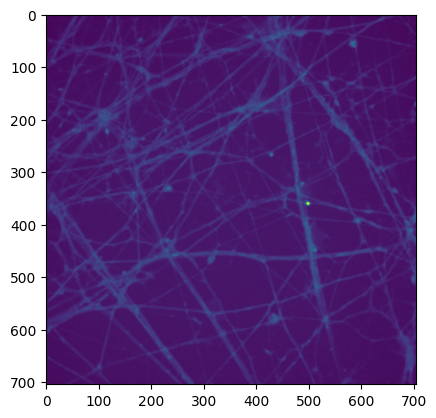

In [429]:
tp = 0
spot_img = images[0]
plt.imshow(spot_img)

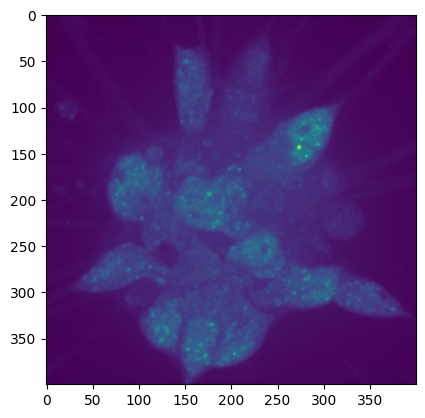

In [419]:
# Demonstration of algorith on a single image:

movie_file = movie_files[0]
print(movie_file)

images = io.imread(movie_file)
print(images.shape)

ex_img = images[0][100:500,150:550]
plt.imshow(ex_img)
plt.show()

#ret = plt.hist(ex_img.flatten(), bins=50)
#plt.yscale("log")
#plt.show()

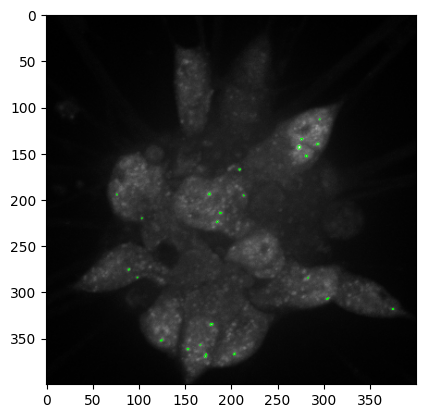

In [420]:
spot_labels, df = find_spots(ex_img, sm_sigma=1, spot_params=[[1, 0.04]], ws=True, min_area=3, 
                           props=('label','area','centroid','mean_intensity'))

# SAVE IMAGE FOR CHECKING 
img_uint8 = exposure.rescale_intensity(ex_img, out_range=(0, 255)).astype('uint8')
image_label_overlay = segmentation.mark_boundaries(img_uint8,
                                                   spot_labels,
                                                   color=[0, 1, 0],
                                                   mode='inner')
plt.imshow(image_label_overlay)

intensity normalization: using min-max normalization with NO absolute intensity upper bound


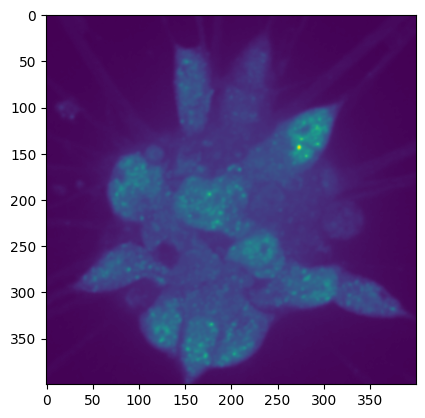

In [343]:
################################
intensity_scaling_param = [0]
gaussian_smoothing_sigma = 1
################################

struct_img = ex_img.copy()

# intensity normalization
struct_img = intensity_normalization(struct_img, scaling_param=intensity_scaling_param)

# smoothing with gaussian filter
structure_img_smooth = image_smoothing_gaussian(struct_img, sigma=gaussian_smoothing_sigma)

plt.imshow(structure_img_smooth)

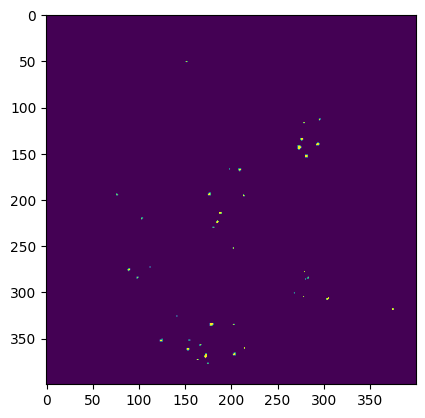

In [344]:
################################
## PARAMETERS for this step ##
s3_param = [[1, 0.04]]
################################

bw = dot_3d_wrapper(structure_img_smooth, s3_param)
plt.imshow(bw)
plt.show()


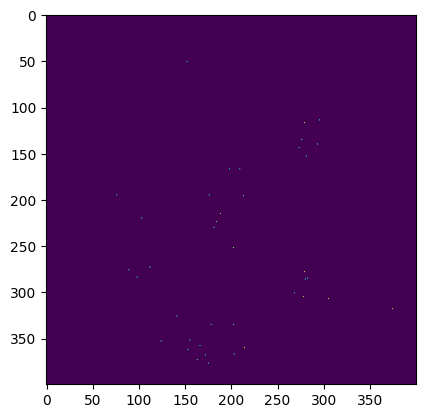

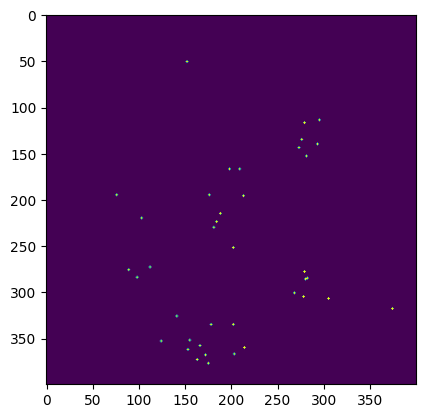

In [346]:
# watershed

min_area = 1
spots_mask0 = morphology.remove_small_objects(bw, min_size = min_area) 

peak_idx = feature.peak_local_max(struct_img, 
                                  labels = measure.label(spots_mask0), 
                                  min_distance = 2)
peak_mask = np.zeros_like(struct_img, dtype=bool)
peak_mask[tuple(peak_idx.T)] = True

plt.imshow(peak_mask)
plt.show()

# why?
ws_seeds = morphology.binary_dilation(peak_mask, footprint=morphology.disk(1))

plt.imshow(ws_seeds)
plt.show()

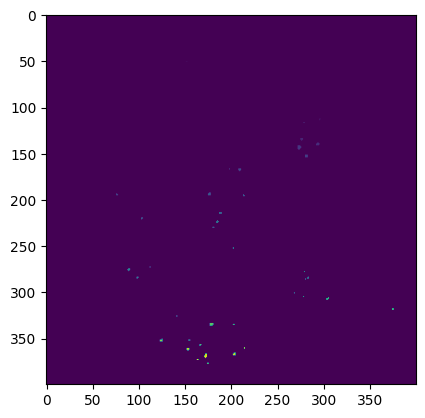

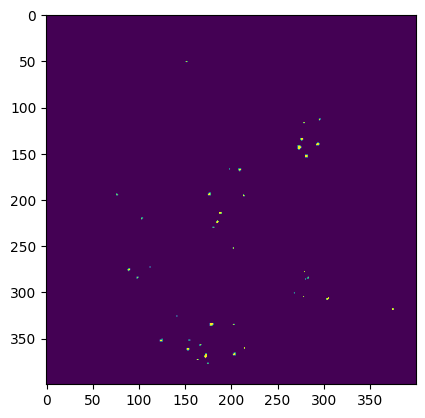

In [353]:
ws_map = -1*ndi.distance_transform_edt(spots_mask0)

seg = segmentation.watershed(ws_map, measure.label(ws_seeds), mask = spots_mask, watershed_line = False)

#seg = morphology.remove_small_objects(seg>0, min_size=min_area)
#print(np.unique(seg.flatten()))

plt.imshow(seg)
plt.show()

plt.imshow(bw)
plt.show()